# Sistemas de recomendación
### Carga de datos de Movie Lens

In [2]:
import pandas as pd

In [4]:
df = pd.read_csv("../datasets/ml-100k/u.data.csv", sep="\t", header=None)

In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
df.shape

(100000, 4)

In [8]:
df.columns = ["UserID", "ItemID", "Rating", "TimeStamp"]

In [9]:
df.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Análisis exploratorio de los ítems

In [10]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

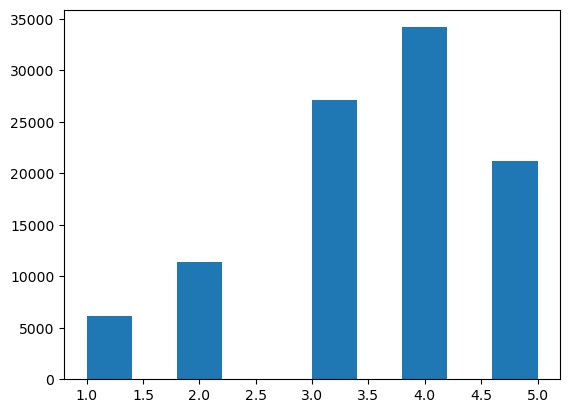

In [11]:
plt.hist(df.Rating)

(array([11459.,  5724., 19359.,  9315.,  9396., 10083.,  6175.,  9603.,
        10048.,  8838.]),
 array([8.74724710e+08, 8.76580903e+08, 8.78437096e+08, 8.80293288e+08,
        8.82149481e+08, 8.84005674e+08, 8.85861867e+08, 8.87718060e+08,
        8.89574252e+08, 8.91430445e+08, 8.93286638e+08]),
 <BarContainer object of 10 artists>)

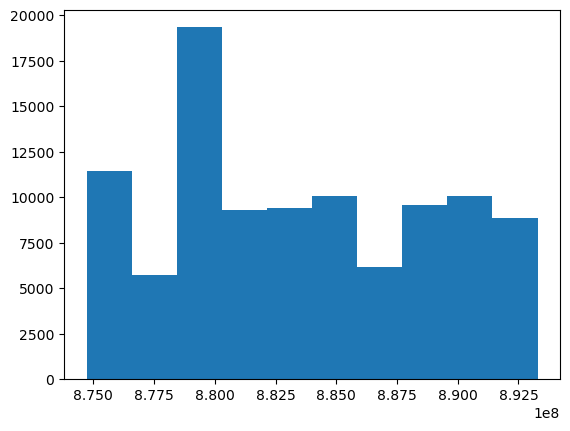

In [12]:
plt.hist(df.TimeStamp)

In [13]:
df.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <BarContainer object of 10 artists>)

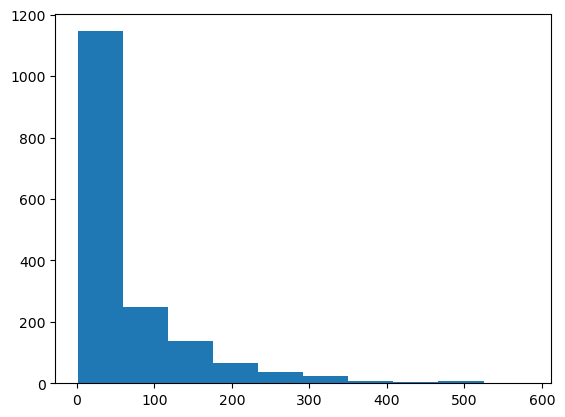

In [14]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count())

### Representación en forma matricial

In [15]:
import numpy as np

In [16]:
n_users = df.UserID.unique().shape[0]
n_users

943

In [17]:
n_items = df.ItemID.unique().shape[0]
n_items

1682

In [18]:
ratings = np.zeros((n_users, n_items))

In [19]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [20]:
type(ratings)

numpy.ndarray

In [21]:
ratings.shape

(943, 1682)

In [22]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [23]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


### Crear conjuntos de entrenamiento y validación

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state=42)

In [26]:
ratings_train.shape

(660, 1682)

In [27]:
ratings_test.shape

(283, 1682)

## Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre los usuarios (distancia del coseno).
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [28]:
import numpy as np
import sklearn

In [29]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [30]:
type(sim_matrix)

numpy.ndarray

In [31]:
sim_matrix.shape

(660, 660)

In [32]:
sim_matrix

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [33]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [34]:
users_predictions

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [86]:
from sklearn.metrics import mean_squared_error

In [87]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[:, actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [116]:
users_predictions.shape

(283, 1682)

In [119]:
ratings_test.shape

(283, 1682)

In [120]:
get_mse(users_predictions, ratings_test)

7.51355110112698

In [121]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_test)
users_predictions = sim_matrix.dot(ratings_test) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
get_mse(users_predictions, ratings_test)

7.51355110112698

## Filtro colaborativo basado en los KNN

In [123]:
from sklearn.neighbors import NearestNeighbors

In [124]:
k = 5

In [126]:
neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')

In [127]:
neighbors.fit(ratings_train)

NearestNeighbors(metric='cosine')

In [128]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [129]:
top_k_distances.shape

(660, 5)

In [130]:
top_k_distances[0]

array([0.        , 0.49780748, 0.55784838, 0.56965585, 0.57163621])

In [131]:
top_k_users.shape

(660, 5)

In [132]:
top_k_users[0]

array([  0, 211,  16, 185, 101])

In [133]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [134]:
users_predicts_k.shape

(660, 1682)

In [135]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.73945823, 2.48622549, 1.76969702, ..., 0.        , 0.        ,
        0.        ],
       [1.95357502, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [136]:
get_mse(users_predicts_k, ratings_train)

4.393656116706791

In [139]:
users_predicts_k = np.zeros(ratings_test.shape)
for i in range(ratings_test.shape[0]):# para cada usuario del conjunto de test CUIDADO, HABIA UN ERROR COMPARANDO CON TEST, EN LUGAR CON RATINGS TRAIN
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T
get_mse(users_predicts_k, ratings_test)

8.956803972455353

In [140]:
ratings_test

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 4., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Filtro colaborativo basado en Items

In [143]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [144]:
neighbors = NearestNeighbors(n_neighbors=n_movies, metric='cosine')

In [145]:
neighbors.fit(ratings_train.T)

NearestNeighbors(metric='cosine', n_neighbors=1682)

In [146]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [147]:
top_k_distances.shape

(1682, 1682)

In [148]:
top_k_distances

array([[1.11022302e-16, 2.76298092e-01, 3.01133276e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 3.58395199e-01, 3.72044790e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 5.43141751e-01, 5.51254903e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.45299804e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 5.13167019e-02, 5.07634036e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [149]:
top_k_items.shape

(1682, 1682)

In [150]:
top_k_items

array([[   0,   49,  180, ..., 1589, 1602, 1679],
       [   1,  232,  160, ..., 1323, 1338, 1679],
       [   2,  762,  409, ..., 1433, 1103, 1680],
       ...,
       [   0, 1127, 1126, ...,  553,  577, 1681],
       [1671, 1680, 1422, ...,  735,  747, 1681],
       [1681, 1596,  766, ...,  700,  715, 1680]])

In [151]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [152]:
item_preds.shape

(660, 1682)

In [153]:
item_preds

array([[3.75385459e-17, 1.81491881e-01, 1.84975068e-01, ...,
        3.53151011e-01, 3.61714398e-01, 3.61072723e-01],
       [6.52494038e-18, 2.76845163e-02, 2.75479698e-02, ...,
        4.81569560e-02, 4.93246906e-02, 4.92371895e-02],
       [3.22219278e-18, 2.56853867e-02, 2.68507499e-02, ...,
        4.45897741e-02, 4.56710098e-02, 4.55899903e-02],
       ...,
       [6.28327592e-18, 6.34395655e-02, 6.23832360e-02, ...,
        1.02259215e-01, 1.04738849e-01, 1.04553044e-01],
       [2.78719676e-17, 1.67722238e-01, 1.68514946e-01, ...,
        3.23424495e-01, 3.31267058e-01, 3.30679396e-01],
       [1.42582031e-17, 2.52640159e-02, 2.61251908e-02, ...,
        6.24256837e-02, 6.39394137e-02, 6.38259864e-02]])

In [154]:
get_mse(item_preds, ratings_train)

11.460962134170675

In [156]:
item_preds = ratings_test.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [157]:
get_mse(item_preds, ratings_test)

11.2152885442602

### Filtrado colaborativo basado en KNN

In [74]:
k = 30
neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [75]:
top_k_distances.shape

(1682, 30)

In [76]:
top_k_items[0]

array([  0,  49, 180, 120, 116, 404,   6, 221,  99, 173, 150, 236,  27,
       171, 117, 256, 203,  78, 741,  94,  97,  68, 209, 124,  81,  24,
       167, 172, 227,  14])

In [77]:
top_k_distances[0]

array([1.11022302e-16, 2.76298092e-01, 3.01133276e-01, 3.04727128e-01,
       3.40321695e-01, 3.47263317e-01, 3.55362834e-01, 3.57212641e-01,
       3.61361048e-01, 3.68666565e-01, 3.73298848e-01, 3.84281189e-01,
       3.95747205e-01, 3.97376861e-01, 4.00149107e-01, 4.00728016e-01,
       4.01613825e-01, 4.03529348e-01, 4.04510017e-01, 4.16455882e-01,
       4.21432410e-01, 4.24757468e-01, 4.26546246e-01, 4.27642772e-01,
       4.28527251e-01, 4.30397179e-01, 4.30995003e-01, 4.33900985e-01,
       4.34947303e-01, 4.35588203e-01])

In [78]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([den]).T

iter 0
iter 50
iter 100
iter 150
iter 200
iter 250
iter 300
iter 350
iter 400
iter 450
iter 500
iter 550
iter 600
iter 650
iter 700
iter 750
iter 800
iter 850
iter 900
iter 950
iter 1000
iter 1050
iter 1100
iter 1150
iter 1200
iter 1250
iter 1300
iter 1350
iter 1400
iter 1450
iter 1500
iter 1550
iter 1600
iter 1650


In [79]:
get_mse(preds, ratings_train)

3.741306021148668

In [80]:
get_mse(preds, ratings_test)

8.639650337967288

In [81]:
preds.shape

(1682, 660)

In [82]:
ratings_train.shape

(660, 1682)

In [83]:
ratings_test.shape

(283, 1682)